# CIFAR100 Image Classification for Aquatic Mammals Using Convolutional Neural Networks from Tensorflow

**Authors: Jhury Kevin Lastre & Paul John Toral**

In recent years, deep learning has revolutionized the field of computer vision by enabling high accuracy image classification. Convolutional Neural Networks (CNNs) are one of the most popular deep learning architectures used in image classification. In this technical report, we explore the CIFAR100 dataset using CNNs for image classification. 

The CIFAR100 dataset is a well-known benchmark in the field of computer vision, consisting of 100 classes with 600 images per class. The images in the dataset are low-resolution (32x32 pixels), making it challenging to classify them accurately. Our goal in this report is to train a CNN model on the CIFAR100 dataset and evaluate its performance in terms of accuracy and computational efficiency. 

We will discuss the dataset, the architecture of our CNN model, the training process, and the evaluation results in detail. The insights gained from this report can be used to improve the accuracy of image classification tasks that we will use in the future.

Goal:


*   Extract Aquatic Mammals data from the CIFAR100 dataset
*   Use data augmentation to yield higher number of samples
*   Normalize the Data
*   Build our Model architecture using the `keras.layers` library
*   Test the accuracy of our model.
*   Plot graphs on loss, epoch, and accuracy to better understand our result






### Importing the necessary libraries

In this section, we imported the following:

✅ Tensorflow.keras - For Convolutional Neural Network Model

✅ imgaug - Image data augmentation

✅ matplotlib.pyplot - For grid plotting and results graph

✅ sklearn.metrics - For a confusion matrix



In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from tensorflow.keras import layers, models, datasets, Sequential, preprocessing, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Dropout,  BatchNormalization
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import os
import imgaug.augmenters as iaa
import sys
import cv2
import random

import matplotlib.pyplot as plt
import pandas as pd


### Data Preprocessing (Extraction)

In this section, we loaded the CIFAR100 dataset and extracted the Aquatic Mammals Coarse Class data together with its Fine Class data. We then flattened the resulting array and changed the labels to only run from 0-4. These 5 distinct labels represent each kind of fine class data that we need to classify and run our model on.

0 - Beaver

1 - Dolphin

2 - Otter

3 - Seal

4 - Whale

In [3]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar100.load_data(label_mode='coarse')
print('Class: {}'.format(len(np.unique(train_labels))))

(fine_train, fine_Trlabels), (fine_test, fine_TsLabels) = keras.datasets.cifar100.load_data(label_mode='fine')
(a, coarse_TrLabels), (b,coarse_TsLabels) = keras.datasets.cifar100.load_data(label_mode='coarse')

idx = []
for i in range(len(coarse_TrLabels)):
  if coarse_TrLabels[i] == 0:
	  idx.append(i)
   

print('Total: {}'.format(len(np.unique(idx))))
idx = np.array(idx)
train_images, train_labels = fine_train[idx], fine_Trlabels[idx]
print("Shape of image: {}".format(train_images.shape))

idx = []
for i in range(len(coarse_TsLabels)):
	if coarse_TsLabels[i] == 0:
		idx.append(i)

idx = np.array(idx)
test_images, test_labels = fine_test[idx], fine_TsLabels[idx]

result = train_labels.flatten()


for i in range(len(train_labels)):
	if(train_labels[i] == 4):
		train_labels[i] = 0
	if(train_labels[i] == 30):
		train_labels[i] = 1
	if(train_labels[i] == 55):
		train_labels[i] = 2 
	if(train_labels[i] == 72):
		train_labels[i] = 3 
	if(train_labels[i] == 95):
		train_labels[i] = 4

for i in range(len(test_labels)):
	if(test_labels[i] == 4):
		test_labels[i] = 0
	if(test_labels[i] == 30):
		test_labels[i] = 1
	if(test_labels[i] == 55):
		test_labels[i] = 2 
	if(test_labels[i] == 72):
		test_labels[i] = 3 
	if(test_labels[i] == 95):
		test_labels[i] = 4



169001437/169001437 [==============================] - 2s 0us/step
Class: 20
Total: 2500
Shape of image: (2500, 32, 32, 3)


### Data Preprocessing (Augmentation)

In this section we leveraged the `imgaug` library to create Data Augmentation Pipelines and add noise to our data. The main reason we need to augment our data for image classification is to improve the generalization ability of our model. 

By creating more diverse images, we are able to expose the model to a wider range of scenarios that it may encounter during the testing phase. This helps the model to learn more robust and meaningful features, which can lead to better performance and less overfitting.


In [4]:
#Data Augmentation
# Define the augmentations you want to apply
seq = iaa.Sequential([
    iaa.Fliplr(1.0), 
    iaa.GaussianBlur(sigma=(0, 1.0)), 
])
seq2 = iaa.Sequential([
    iaa.ChannelShuffle(p=0.5),
    iaa.WithColorspace(
        to_colorspace="HSV",
        from_colorspace="RGB",
        children=iaa.WithChannels(0, iaa.Add((-50, 50)))
    ),
    iaa.WithColorspace(
        to_colorspace="HSV",
        from_colorspace="RGB",
        children=iaa.WithChannels(1, iaa.Add((-50, 50)))
    ),
    iaa.WithColorspace(
        to_colorspace="HSV",
        from_colorspace="RGB",
        children=iaa.WithChannels(2, iaa.Add((-50, 50)))
    )
])
seq3 = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.CoarseDropout((0.1, 0.3), size_percent=(0.02, 0.05))),
    iaa.Sometimes(0.5, iaa.Sometimes(0.5, iaa.ChannelShuffle(0.5))),
    iaa.Sometimes(0.5, iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))),
])

seq4 = iaa.Sequential([
    iaa.Multiply((0.5, 1.5), per_channel=0.5),
    iaa.ContrastNormalization((0.5, 1.5)),
    iaa.FrequencyNoiseAlpha(
        exponent=(-4, 0),
        first=iaa.Multiply((0.5, 1.5), per_channel=True),
        second=iaa.LinearContrast((0.5, 2.0))
    )
])



/usr/local/lib/python3.8/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)
/usr/local/lib/python3.8/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


### Data Preprocessing (Applying the Augmentations)

We then applied the augmentation to the original training image data 10 times. Each pipeline is unique and therefore each set would yield a different kind of augmented output. 

In many cases, collecting a large dataset for training an image classification model can be costly and time-consuming. However, by augmenting the existing data, we can effectively increase the size of the dataset without incurring additional costs.

After doing this process, we yielded a total of 12,500 training data from our original number of 2,500 training data.

In [5]:


# Create a list to store the augmented images and their labels
aug_train_images = []
aug_train_labels = []
aug_train_images_s2 = []
aug_train_labels_s2 = []
aug_train_images_s3 = []
aug_train_labels_s3 = []
aug_train_images_s4 = []
aug_train_labels_s4 = []


# Iterate over the training images and their labels
for i in range(len(train_images)):
    image = train_images[i]
    label = train_labels[i]
    
    # Apply the augmentations
    aug_image = seq(image=image)
    aug_image2 = seq2(image=image)
    aug_image3 = seq3(image=image)
    aug_image4 = seq4(image=image)

    
    # Add the augmented image and its label to the list
    aug_train_images.append(aug_image.reshape(32,32,3))
    aug_train_labels.append(label)
    aug_train_images_s2.append(aug_image2.reshape(32,32,3))
    aug_train_labels_s2.append(label)
    aug_train_images_s3.append(aug_image3.reshape(32,32,3))
    aug_train_labels_s3.append(label)
    aug_train_images_s4.append(aug_image4.reshape(32,32,3))
    aug_train_labels_s4.append(label)
 


# Convert the lists to numpy arrays
aug_x_train = np.array(aug_train_images)
aug_y_train = np.array(aug_train_labels)
aug_x_train_s2 = np.array(aug_train_images_s2)
aug_y_train_s2 = np.array(aug_train_labels_s2)
aug_x_train_s3 = np.array(aug_train_images_s3)
aug_y_train_s3 = np.array(aug_train_labels_s3)
aug_x_train_s4 = np.array(aug_train_images_s4)
aug_y_train_s4 = np.array(aug_train_labels_s4)


# Concatenate the augmented images and their labels with the original training set
train_images_aug = np.concatenate([train_images, aug_x_train, aug_x_train_s2, aug_x_train_s3, aug_x_train_s4])
train_labels_aug = np.concatenate([train_labels, aug_y_train, aug_y_train_s2, aug_y_train_s3, aug_y_train_s4])


### Data Preprocessing (Data Verification)

We then verified if the aforementioned processes were successful by plotting our training data in a 10x2 grid using the `matplotlib.pyplot` library. 

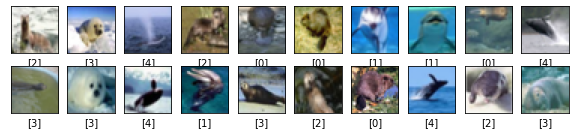

Total: 500
12500


In [7]:
plt.figure(figsize=(10,2))
for i in range(0,20):
  plt.subplot(2,10,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images_aug[i], cmap=plt.cm.binary)
  plt.xlabel(train_labels_aug[i])
plt.show()
print('Total: {}'.format(len(np.unique(idx))))
print(len(train_images_aug))

### Data Preprocessing (Normalization)

One of the challenges in training machine learning models on image data is the scale of the pixel values. The pixel values can range from 0 to 255 for each color channel in an RGB image, and these large values can cause numerical instability during the training process. For example, if the weights in the model are initialized randomly and the input values are large, the resulting outputs can also be large, which can cause the activation functions to saturate and slow down the learning process.

By normalizing the pixel values to be between 0 and 1, we can reduce the scale of the input values and make the model more stable during the training process. Normalization also has the effect of centering the data around zero, which can make the optimization process more efficient by reducing the likelihood of the model getting stuck in local optima.

In [ ]:
train_labels = to_categorical(train_labels, num_classes = 5, dtype ="int32")
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images_aug / 255.0, test_images / 255.0

### Building our Convolutional Base

From the original tensorflow documentation, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size.

`Conv2D` is a type of layer in a CNN that performs convolution operations on the input images. Convolution is a mathematical operation that involves sliding a small filter over the input image and computing the dot product between the filter and the image pixels. The result of this operation is a feature map that highlights certain patterns in the input image. 

The Conv2D layer learns the weights of the filters during the training process, which allows the network to learn meaningful features from the input images. By stacking multiple Conv2D layers on top of each other, the network can learn more complex and abstract features.

`MaxPooling2D`, on the other hand, is a layer in a CNN that downsamples the feature maps produced by the Conv2D layers. MaxPooling2D works by dividing the input feature map into non-overlapping subregions and selecting the maximum value in each subregion. This operation reduces the dimensionality of the feature maps, which can help to make the network more computationally efficient and less prone to overfitting.

In [ ]:
model = models.Sequential()
model.add(Conv2D(input_shape = (32,32,3), kernel_size=(2,2), padding='same', strides=(2,2), filters=32))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same'))
model.add(Conv2D(kernel_size=(2,2), padding='same', strides=(2,2), filters=64))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same'))



### Regularization (Dropout) and Adding Dense Layers

To finish the model, input the final output tensor from the convolutional base  into one or more Dense layers for classification. Dense layers use vectors (which are 1D) as input and produce a 3D tensor as output. We Flatten the 3D output to 1D first, then add one or more Dense layers on top. 

Because our data has 5 Fine Class Categories for Aquatic Mammals, we need a final Dense layer with 5 outputs.

In [ ]:
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(5,activation='softmax'))

model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 16, 16, 32)        416       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 8, 8, 64)          8256      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 4096)              0         
                                                                 
 dense_47 (Dense)            (None, 256)             

### Model Compilation

We use the Keras API to compile our model architecture. 

`optimizer=sgd` is our chosen optimization algorithm which stands for Stochastic Gradient Descent, which is a popular optimization algorithm used in machine learning. In SGD, the weights of the neural network are updated in small batches during each iteration, with the goal of minimizing the loss function that is being optimized. 

`loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)` specifies the loss function used to measure the difference between the predicted and actual labels during training. 

`metrics=['accuracy']` provides the evaluation metric used to monitor the model's performance during training. The accuracy metric, which quantifies the proportion of correctly categorized images in the training and validation sets, is used in this situation.

In [ ]:
# Compile the model
model.compile(optimizer='sgd',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Regularization (Early Stopping Callback)

Early stopping allows us to stop the training process whenever it accuracy drops 3 times, `patience=3` before it reaches the maximum number of epochs, saving time and computational resources. Early stopping stops the training process before the model becomes too complex, preventing overfitting and improving our generalization performance

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

### Training the Model

We use the `model.fit` function to train our model with 200 epochs. Here, we are passing our augmented training data with their labels, and our testing data as validation arguments. We then print our loss and accuracy

In [ ]:
history = model.fit(train_images, train_labels_aug, epochs=200, 
                    validation_data=(test_images[0:400], test_labels[0:400]), callbacks=[early_stopping])

score= model.evaluate(test_images[400:],test_labels[400:], verbose=0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

Epoch 1/200
391/391 [==============================] - 5s 13ms/step - loss: 0.9826 - accuracy: 0.6052 - val_loss: 1.0847 - val_accuracy: 0.5625
Epoch 2/200
391/391 [==============================] - 7s 19ms/step - loss: 0.9644 - accuracy: 0.6145 - val_loss: 1.0588 - val_accuracy: 0.5650
Epoch 3/200
391/391 [==============================] - 12s 31ms/step - loss: 0.9485 - accuracy: 0.6270 - val_loss: 1.0737 - val_accuracy: 0.5450
Epoch 4/200
391/391 [==============================] - 8s 21ms/step - loss: 0.9184 - accuracy: 0.6357 - val_loss: 1.0722 - val_accuracy: 0.5675
Epoch 5/200
391/391 [==============================] - 4s 10ms/step - loss: 0.8999 - accuracy: 0.6482 - val_loss: 1.0661 - val_accuracy: 0.5725
Epoch 6/200
391/391 [==============================] - 11s 28ms/step - loss: 0.8887 - accuracy: 0.6493 - val_loss: 1.1288 - val_accuracy: 0.5475
Epoch 7/200
391/391 [==============================] - 12s 31ms/step - loss: 0.8567 - accuracy: 0.6657 - val_loss: 1.0865 - val_accura

### Model Verification (Prediction probability for each class on a certain test image)

In the following sections, we examine different test images and derive highest class probability. The `class predictions` array is a numpy array that contains each probability in a class for the image where the model is tested against. 

Although some images are not accurately determined, this is brought by the lack of accuracy within our model and the difficulty of the dataset since mammals contain several features and some of them even have the same color.

For example in `image 3`, our model described it to be **96% beaver** but it is actually an otter. If we look at the picture visually, it is hard to distinguish both mammals because of the similarity in body shape and color.

1/1 [==============================] - 0s 70ms/step
92.87713170051575 % probability for beaver


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


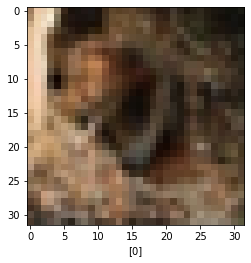

In [ ]:
categories_aquatic = ["beaver", "dolphin", "otter", "seal", "whale"]

image_batch = np.expand_dims(test_images[3], axis=0) 
class_predictions = model.predict(image_batch)
max_value = np.max(class_predictions)
index = np.argmax(class_predictions)
print('{0} % probability for {1}'.format(max_value * 100, categories_aquatic[index]))
plt.imshow(test_images[3], cmap=plt.cm.binary)
plt.xlabel(test_labels[3])
plt.show()

1/1 [==============================] - 1s 801ms/step
89.22249674797058 % probability for dolphin


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


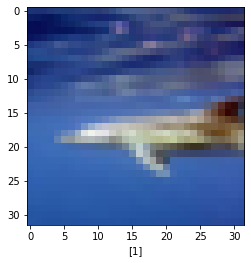

In [ ]:
image_batch = np.expand_dims(test_images[12], axis=0) 
class_predictions = model.predict(image_batch)
max_value = np.max(class_predictions)
index = np.argmax(class_predictions)
print('{0} % probability for {1}'.format(max_value * 100, categories_aquatic[index]))
plt.imshow(test_images[12], cmap=plt.cm.binary)
plt.xlabel(test_labels[12])
plt.show()




1/1 [==============================] - 1s 826ms/step
96.68521881103516 % probability for beaver


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


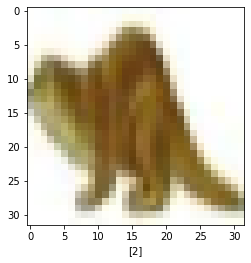

In [ ]:
image_batch = np.expand_dims(test_images[19], axis=0) #otter
class_predictions = model.predict(image_batch)
max_value = np.max(class_predictions)
index = np.argmax(class_predictions)
print('{0} % probability for {1}'.format(max_value * 100, categories_aquatic[index]))
plt.imshow(test_images[19], cmap=plt.cm.binary)
plt.xlabel(test_labels[19])
plt.show()


1/1 [==============================] - 0s 20ms/step
34.662190079689026 % probability for otter


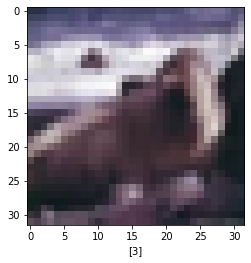

In [ ]:
image_batch = np.expand_dims(test_images[25], axis=0) #seal
class_predictions = model.predict(image_batch)
max_value = np.max(class_predictions)
index = np.argmax(class_predictions)
print('{0} % probability for {1}'.format(max_value * 100, categories_aquatic[index]))
plt.imshow(test_images[25], cmap=plt.cm.binary)
plt.xlabel(test_labels[25])
plt.show()



1/1 [==============================] - 0s 20ms/step
87.06789016723633 % probability for whale


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


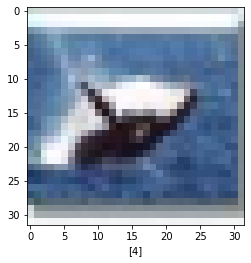

In [ ]:
image_batch = np.expand_dims(test_images[8], axis=0) #whale
class_predictions = model.predict(image_batch)
max_value = np.max(class_predictions)
index = np.argmax(class_predictions)
print('{0} % probability for {1}'.format(max_value * 100, categories_aquatic[index]))
plt.imshow(test_images[8], cmap=plt.cm.binary)
plt.xlabel(test_labels[8])
plt.show()

### Confusion Matrix Heatmap and Classification Report

In this explore, we explored our yielded test accuracy through a confusion matrix heatmap using `seaborn` with **100 test images and test labels**.

From the report, we can see that we have an average of *67.12%* which is the fraction of correctly predicted positive samples out of the total samples.

We also yielded a recall of *67%* which is the correctly predicted positive samples out of the total actual positive samples and an accuracy of *67%* from the F1-Score which pertains to the harmonic mean of the precision and recall.

4/4 [==============================] - 0s 4ms/step


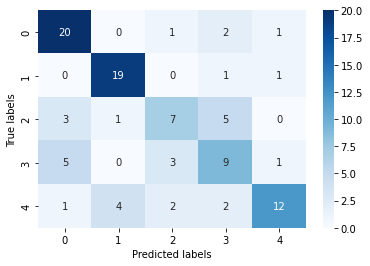

              precision    recall  f1-score   support

           0     0.6897    0.8333    0.7547        24
           1     0.7917    0.9048    0.8444        21
           2     0.5385    0.4375    0.4828        16
           3     0.4737    0.5000    0.4865        18
           4     0.8000    0.5714    0.6667        21

    accuracy                         0.6700       100
   macro avg     0.6587    0.6494    0.6470       100
weighted avg     0.6712    0.6700    0.6633       100



In [ ]:
Y_pred = model.predict(test_images[400:])
Y_pred_classes = np.argmax(Y_pred, axis = 1)
cm = confusion_matrix(test_labels[400:], Y_pred_classes)

# Visualize confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Interpret confusion matrix
report = classification_report(test_labels[400:], Y_pred_classes, digits=4)
print(report)


### Plot of Accuracy vs. Epochs
From the plot, we can see a gradually increasing accuracy from 0.60 to 0.67 in 7 epochs which indicates that the model's performance improved over time during training. The plot suggests that the model was not initially effective, but as it processed more data, it gradually learned to make more accurate predictions. This plot also suggests that the model may continue to improve with additional training, as the accuracy has not yet plateaued.

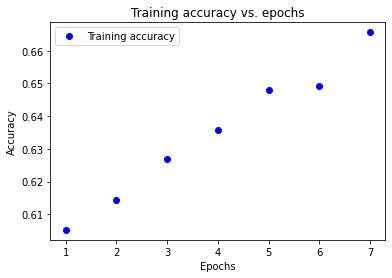

In [ ]:
# Access the accuracy values from the history object
accuracy = history.history['accuracy']

# Access the number of epochs
epochs = range(1, len(accuracy) + 1)

# Plot the accuracy vs. epochs
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.title('Training accuracy vs. epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


### Plot of Loss vs. Epochs

The plot shows a gradually decreasing loss from 0.98 to approximately 0.86 in 7 epochs which indicates that the model's performance improved significantly over time during training. The decreasing loss suggests that the model was able to more accurately predict the outcome with each epoch. This plot indicates that the model started with a relatively high error, but gradually became more precise in its predictions. The continued downward trend of the loss suggests that the model's performance may continue to improve with additional training, as there is still room for the model to further reduce its prediction errors.

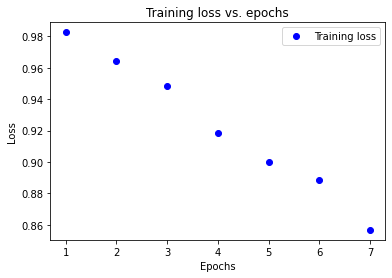

In [ ]:
import matplotlib.pyplot as plt

# Access the loss values from the history object
loss = history.history['loss']

# Access the number of epochs
epochs = range(1, len(loss) + 1)

# Plot the loss vs. epochs
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss vs. epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Is it Overfit? (Training and Validation Loss vs. Epochs)

From the graph below, our training loss is lower than the validation loss which indicates overfitting. The amount of data to at least generate an acceptable amount of accuracy is about 50,000 images. We have augmented our data to yield 12,500 samples but still, that number is still far from the desired value. Hence, overfitting is highly likely.

To compensate for the lack of data, we have used regularization techniques like Dropout, and Early Stopping to allieviate the overfitting issue.

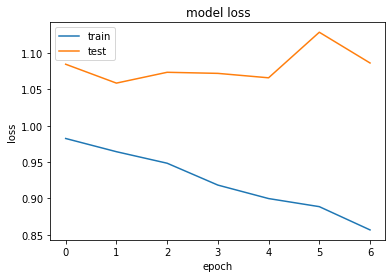

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Final Results
Test Accuracy: 67%

Loss: 1.0159

In [ ]:
test_loss, test_acc = model.evaluate(test_images[400:],  test_labels[400:], verbose=2)

4/4 - 0s - loss: 1.0159 - accuracy: 0.6700 - 42ms/epoch - 10ms/step


## Challenges Encountered


#### Data Preprocessing

Data preprocessing was a challenge especially when extracting the Aquatic Mammals data from the CIFAR100 dataset. This is brought by our lack of experience in doing Python. We have used the previous example given by our professor `numberclassification.py` and wrote the code for extraction from there. 

We also explored different resources to augment, verify, and normalize our data.

#### CNN Model Architecture

To build our model we used the official documentation made by TensorFlow for CNNs.

[https://www.tensorflow.org/tutorials/images/cnn](https://)

The challenge here now lies on how we can build our model to achieve a high accuracy. To do that, we added multiple layers of `Conv2D` and `MaxPooling` that extract features from the input image. We also tried different optimizers like `adam`, `sgd`, `momentum`. We stuck with `sgd` since it yielded a higher accuracy for our model.

We then flattened the model and added a `Dropout` of 0.5 to regularize our model. Lastly we used the `Dense` function to perform the classification or regression task. 

We have tried using different kinds of layers, mixing and matching different combinations, increasing the number of epochs, and even adding L2 and L1 regularization but the accuracy yielded even got worse. 

After training the data multiple times, we noticed that once accuracy drops after 2-3 epochs from the highest accuracy recorded, it was difficult for it to come back up. To resolve this issue we leveraged the `EarlyStopping` function and set `patience=3`.

## Recommendation

To achieve a higher accuracy, the researcher could optimize the different hyperparameters and experiment different combinations to find the most optimal configuration. 

The researcher could also use transfer learning and use a pre-trained CNN model like VGG, ResNet or Inception as a starting point and fine-tune the model for the CIFAR100 dataset. 

Access to VGG16 documentation: [https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16](https://)



## Conclusion and Key Takeaways

The exercise was a great way to help us understand machine learning a lot better. We especially needed this because our thesis will focus specifically on image processing and computer vision. We have gained a lot of insight regarding Convolutional Neural Networks and how it will help humans in different sectors of the society.

Right now, AI is already a dominant force within the industry. From support chatbots to autonomous vehicles, to even generating art. Most tasks that we, humans, find mundane and repetitive are being replaced by AI at an increasingly rapid rate. 

Overall, the impact of AI on society can be transformative, with the potential to revolutionize the way we live, work, and interact with the world around us. 

Whenever we use tools that are powered by AI technology, we ponder on how much humanity will be left? While the potential benefits are great, we must maintain our values, empathy, and creativity as fundamental components of the human experience. The task ahead is to harness the power of AI while retaining the distinctive human characteristics that make us who we are.



*- Jhury Kevin Lastre & Paul John Toral*
